In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.probability import FreqDist
from wordcloud import WordCloud
!python -m spacy download fr_core_news_md -qq
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import fr_core_news_md
from PyPDF2 import PdfFileReader
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

import warnings
warnings.filterwarnings("ignore")

✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')


c:\Users\ibrao\AppData\Local\pypoetry\Cache\virtualenvs\nlp1-rattrapage-7qUmAFjS-py3.10\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
c:\Users\ibrao\AppData\Local\pypoetry\Cache\virtualenvs\nlp1-rattrapage-7qUmAFjS-py3.10\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
c:\Users\ibrao\AppData\Local\pypoetry\Cache\virtualenvs\nlp1-rattrapage-7qUmAFjS-py3.10\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


## 1. Collecte des données

In [2]:
def get_documents(path):
  """
  Extract text from a PDF file.
  """
  dataset = []
  for file in os.listdir(path):
    if file.endswith('.pdf'):
      pdf_file = open(path + '/' + file, 'rb')
      pdf = PdfFileReader(pdf_file)
      page = pdf.pages[-1]
      if file == 'BEA2016-0759.pdf':
        text = page.extract_text()
        text = text.split('Conclusion')[1]
      elif file == 'n-ca001215_05.pdf':
        # La section Conclusion est à l'avant dernière page
        # contrairement aux 2 autres documents
        # text = ""
        # page = pdf.pages[-1]
        # text =  page.extract_text()
        # print(text)
        # text = text.split('Conclusion')[1]
        text = """
        L’accident  est  probablement  dû  à  l’application
        lors  de  l’atterrissage  à  l’aéroport  de  Limoges 
        d’un  effort  sur  le  train  avant  excédant  sa 
        capacité  de  résistance,  affectée  par  des  endommagements
        précédents.  Cet  effort  a  provoqué  la  progression 
        d’une  fissure  antérieure,  qui  s’est  poursuivie 
        jusqu’à  la  rupture  statique  du  bâti.  Cet  effort
        n’a pas été rapporté par le pilote. Via  la  lettre
        d’information  n°00-560-03  éditée  en  juillet  2000
        par  le  concepteur  de  la  remotorisation, l’exploitant
        avait été averti : ¾ d’une  part  de  l’occurrence  de
        deux  cas  d’apparition  de  criques  sur  des  bâtis 
        moteurs du même type que celui du N429CA, ¾ et d’autre
        part de la possibilité d’installer sur l’avion une version
        renforcée du bâti. Malgré  cette  lettre  service, 
        l’exploitant  a  choisi  de  ne  pas  réaliser  rapidement 
        cette  modification, qui aurait pu éviter l’accident. Le fait
        que l’exploitant n’ait pu détecter un endommagement présent
        avant le vol de l’accident a contribué à l’événement.
        """
        
      elif file == 'n-tg000906_06.pdf':
        text = page.extract_text()
        text = text.split('CONCLUSION')[1]
       
      row = [str(file), text]
    dataset.append(row)
  df = pd.DataFrame(dataset, columns=['PDF', 'Content'])
  return df


df = get_documents('../docs')
df.head()

,PDF,Content
0,BEA2016-0759.pdf,\n\n\nLe pilote s’est désaxé de la trajectoire...
1,n-ca001215_05.pdf,\n L’accident est probablement dû à...
2,n-tg000906_06.pdf,\n\n\nL’accident résulte d’une décision inappr...


In [3]:
df['Content'][2]

'\n\n\nL’accident résulte d’une décision inappropriée de l’équipage dans le choix \n\n\ndu/uni00A0cheminement utilisé pour réaliser un largage de barrage. Ce choix a probablement \n\n\nété dicté par le fait que le copilote, pilote en fonction, pouvait mieux contrôler de sa \n\n\nplace, notamment, le virage à droite sur la ville de Burzet. L’évolution à proximité \n\n\ndu relief était inadaptée pour un avion de ce gabarit et nécessitait de la part de \n\n\nl’équipage un pilotage aux limites du domaine de vol. La dernière phase de vol, \n\n\nréalisée sans doute au second régime de vol, n’a pas permis au pilote de reprendre \n\n\nsuffisamment de hauteur pour s’affranchir du relief. La charge de travail du copilote, \n\n\npilote en fonction, ne lui a pas laissé le temps d’exécuter un largage d’urgence pour \n\n\nalléger l’avion et dégager dans la vallée. Le soleil de face et la présence de fumée \n\n\ndans la dernière ligne droite ont amené l’équipage à faire une appréciation erronée \n\n\

## 2. Processer les données

In [4]:
# Notre modèle spqcy:
nlp = fr_core_news_md.load()
# Tages à supprimer du text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
tokens = []
for summary in nlp.pipe(df['Content']):
   report_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   tokens.append(report_tok)

df['tokens'] = tokens
df['tokens']

0    [pilote, désaxé, trajectoire, approche, instru...
1    [accident, devoir, application, atterrissage, ...
2    [accident, résulte, décision, inapproprié, équ...
Name: tokens, dtype: object

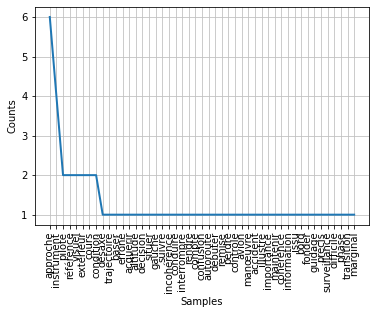

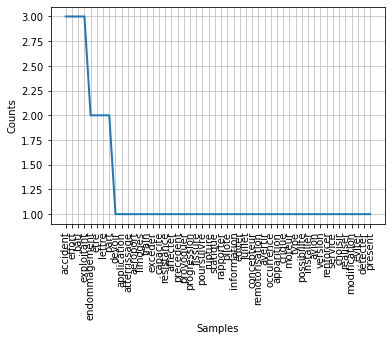

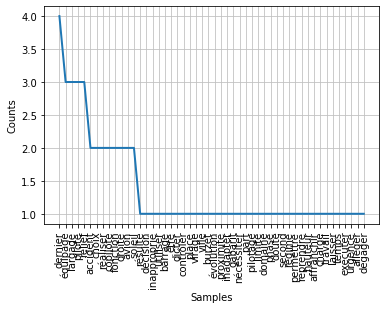

In [5]:
for doc in df['tokens']:  
    frequency_dist = FreqDist(doc)
    sorted_frequency_dist = sorted(frequency_dist, key=frequency_dist.__getitem__, reverse=True)
    large_words = dict([(k, v) for k, v in frequency_dist.items() if len(k) > 3])
    frequency_dist = nltk.FreqDist(large_words)
    frequency_dist.plot(50, cumulative=False)

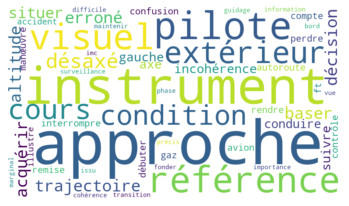

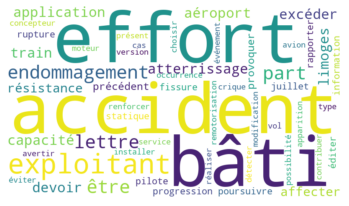

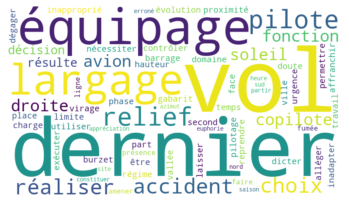

In [6]:
import matplotlib.pyplot as plt
for doc in df['tokens']:
        frequency_dist = nltk.FreqDist(doc)
        wcloud = WordCloud(width=800, height=460,
                background_color='white',
                random_state=0).generate_from_frequencies(frequency_dist)
        # plotting du wordcloud
        plt.imshow(wcloud, interpolation="bilinear")
        plt.axis('off')
        (-.5, 500, 199.5, -.5)
        plt.show()

## 3. Creation du dictionnaire et du corpus

### Creation du dictionnary

In [7]:
dictionary = Dictionary(df['tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
print(dictionary.token2id)

{}


### Création de notre corpus

In [8]:
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=5, workers = 4, passes=10)
corpus

ValueError: cannot compute LDA over an empty collection (no terms)

## 4. Création du modèle

## Calcul du score de cohérence à l'aide de $C_{umass}$ :

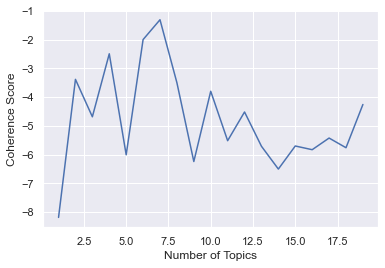

In [ ]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

## Calculating the coherence score using $C_v$:

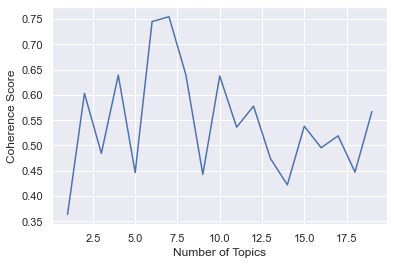

In [ ]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [ ]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=20, num_topics=3, workers = 4, passes=100)

## 5. Visualisation of topics

In [ ]:
lda_model.print_topics()

[(0,
  '0.028*"accident" + 0.028*"bâti" + 0.028*"effort" + 0.028*"exploitant" + 0.020*"part" + 0.020*"être" + 0.019*"endommagement" + 0.019*"lettre" + 0.011*"information" + 0.011*"fissure"'),
 (1,
  '0.053*"approche" + 0.036*"instrument" + 0.020*"pilote" + 0.019*"extérieur" + 0.019*"visuel" + 0.019*"cours" + 0.019*"condition" + 0.019*"référence" + 0.011*"phase" + 0.011*"erroné"'),
 (2,
  '0.030*"vol" + 0.030*"dernier" + 0.023*"pilote" + 0.023*"relief" + 0.023*"largage" + 0.023*"équipage" + 0.016*"avion" + 0.016*"réaliser" + 0.016*"fonction" + 0.016*"droite"')]

Visualisation les sujets et les mots associés à chaque sujet:

## 6. Approche avec le *TF-IDF*

In [ ]:
threashold = .5

In [ ]:
# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# iterate to retrieve documents
text = [item for sublist in df['tokens'].tolist() for item in sublist]
# create the transform
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=0.005)
# fit the transform
tfidf_matrix = tfidf_vectorizer.fit_transform(text)
print(tfidf_vectorizer.vocabulary_)
print(tfidf_vectorizer.idf_)

{'pilote': 23, 'approche': 1, 'instrument': 18, 'référence': 26, 'visuel': 28, 'extérieur': 15, 'erroné': 13, 'décision': 10, 'avion': 2, 'cours': 7, 'accident': 0, 'information': 17, 'condition': 5, 'phase': 22, 'effort': 11, 'endommagement': 12, 'bâti': 3, 'être': 31, 'lettre': 20, 'exploitant': 14, 'part': 21, 'réaliser': 25, 'vol': 29, 'équipage': 30, 'choix': 4, 'largage': 19, 'copilote': 6, 'fonction': 16, 'droite': 9, 'relief': 24, 'dernier': 8, 'soleil': 27}
[4.4657359  4.4657359  4.80220814 5.02535169 5.31303376 5.31303376
 5.31303376 5.31303376 4.80220814 5.31303376 5.31303376 5.02535169
 5.31303376 5.31303376 5.02535169 5.31303376 5.31303376 5.31303376
 4.80220814 5.02535169 5.31303376 5.02535169 5.31303376 4.4657359
 5.02535169 5.02535169 5.31303376 5.31303376 5.31303376 4.61988658
 5.02535169 5.02535169]


## Wordcloud avec TFIDF

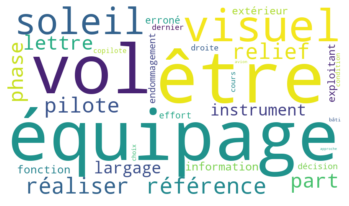

In [ ]:
wcloud = WordCloud( width=800, height=460,
                background_color='white',
                random_state=0).generate_from_frequencies(tfidf_vectorizer.vocabulary_)
# plotting du wordcloud
plt.imshow(wcloud, interpolation="bilinear")
plt.axis('off')
(-.5, 500, 199.5, -.5)
plt.show()

## Création du modèle

In [ ]:
# corpus = [dictionary.doc2bow(doc) for doc in tfidf_vectorizer.vocabulary_]

lda_model = LdaMulticore(corpus=tfidf_vectorizer.vocabulary_, id2word=dictionary, num_topics=5, workers = 4, passes=10)

## Calcul du score de cohérence à l'aide de $C_{umass}$ :

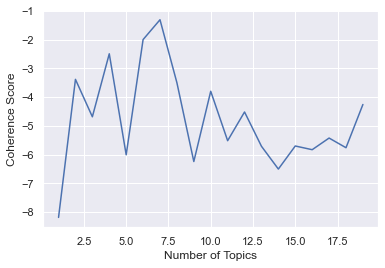

In [ ]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [ ]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=20, num_topics=3, workers = 4, passes=100)

## 5. Visualisation of topics

In [ ]:
lda_model.print_topics()

[(0,
  '0.028*"accident" + 0.028*"bâti" + 0.028*"effort" + 0.028*"exploitant" + 0.020*"part" + 0.020*"être" + 0.019*"endommagement" + 0.019*"lettre" + 0.011*"information" + 0.011*"fissure"'),
 (1,
  '0.053*"approche" + 0.036*"instrument" + 0.020*"pilote" + 0.019*"extérieur" + 0.019*"visuel" + 0.019*"cours" + 0.019*"condition" + 0.019*"référence" + 0.011*"phase" + 0.011*"erroné"'),
 (2,
  '0.030*"vol" + 0.030*"dernier" + 0.023*"pilote" + 0.023*"relief" + 0.023*"largage" + 0.023*"équipage" + 0.016*"avion" + 0.016*"réaliser" + 0.016*"fonction" + 0.016*"droite"')]